# Особенности формирования признаков для данных различных типов

- Большое количество техник обработки признаков ориентировано на числовые и категориальные признаки.
- А как быть с признаками других видов? Например таких, как дата-время, IP-адрес, URL-адрес, строка (которая не является категориальным признаком).

## Загрузка и первичный анализ данных

Используем набор данных [web log dataset.](https://www.kaggle.com/shawon10/web-log-dataset)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import ipaddress
import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
data = pd.read_csv('data/weblog.csv', sep=',')

In [3]:
data.shape

(15789, 4)

In [4]:
data.head()

,IP,Time,URL,Status
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200


In [5]:
# Целевой признак
data['Status'].value_counts()

200    11330
302     3498
304      658
404      251
206       52
Name: Status, dtype: int64

In [6]:
# Закодируем целевой признак
target_le = LabelEncoder()
data['status_le'] = target_le.fit_transform(data['Status'])
data['status_le'].unique(), target_le.inverse_transform(data['status_le'].unique())

(array([0, 2, 3, 1, 4], dtype=int64),
 array([200, 302, 304, 206, 404], dtype=int64))

In [7]:
data.dtypes

IP           object
Time         object
URL          object
Status        int64
status_le     int64
dtype: object

## Выделение признаков из URL-адреса

In [8]:
# Проверка наличия подстроки в URL
def substr_in_url(substr):
    lsubstr = substr.lower()
    return data.apply(lambda x: 1 if lsubstr in x['URL'].lower() else 0, axis=1)

In [9]:
data['is_get'] = substr_in_url('GET')
data['is_php'] = substr_in_url('PHP')
data['is_js'] = substr_in_url('JS')
data['is_woff'] = substr_in_url('WOFF')
url_features = ['is_get', 'is_php', 'is_js', 'is_woff']

In [10]:
data.head()

,IP,Time,URL,Status,status_le,is_get,is_php,is_js,is_woff
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200,0,1,1,0,0
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302,2,0,1,0,0
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200,0,1,1,0,0
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200,0,1,0,1,0
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200,0,1,0,1,0


## Обработка даты и времени

In [11]:
# Сконвертируем дату и время в нужный формат
data['dt'] = data.apply(lambda x: pd.to_datetime(x['Time'], format='[%d/%b/%Y:%H:%M:%S'), axis=1)

In [12]:
data.head()

,IP,Time,URL,Status,status_le,is_get,is_php,is_js,is_woff,dt
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:58:55
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302,2,0,1,0,0,2017-11-29 06:59:02
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:59:03
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:04
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:06


In [13]:
data.dtypes

IP                   object
Time                 object
URL                  object
Status                int64
status_le             int64
is_get                int64
is_php                int64
is_js                 int64
is_woff               int64
dt           datetime64[ns]
dtype: object

Для работы с датами, временем и временными интервалами используются [возможности библиотеки NumPy.](https://numpy.org/doc/stable/reference/arrays.datetime.html)

### Выделение стандартных признаков даты и времени

In [14]:
# День
data['day'] = data['dt'].dt.day
# Месяц
data['month'] = data['dt'].dt.month
# Год
data['year'] = data['dt'].dt.year
# Часы
data['hour'] = data['dt'].dt.hour
#Минуты
data['minute'] = data['dt'].dt.minute
#Секунды
data['second'] = data['dt'].dt.second
#Неделя года
data['week'] = data['dt'].dt.isocalendar().week
#Квартал
data['quarter'] = data['dt'].dt.quarter
#День недели 
data['dayofweek'] = data['dt'].dt.dayofweek
#Выходной день
data['day_name'] = data['dt'].dt.day_name()
data['is_holiday'] = data.apply(lambda x: 1 if x['dt'].dayofweek in [5,6] else 0, axis=1)

In [15]:
#Проверка определения выходных дней
#data[data['day_name']=='Monday'] 
#data[data['day_name']=='Sunday'] 
#data[data['day_name']=='Saturday'] 

По аналогии с выходными днями часто формируется календарь потенциальных аномалий (например, праздники по китайскому календарю).

In [16]:
data.head()

,IP,Time,URL,Status,status_le,is_get,is_php,is_js,is_woff,dt,...,month,year,hour,minute,second,week,quarter,dayofweek,day_name,is_holiday
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:58:55,...,11,2017,6,58,55,48,4,2,Wednesday,0
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302,2,0,1,0,0,2017-11-29 06:59:02,...,11,2017,6,59,2,48,4,2,Wednesday,0
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:59:03,...,11,2017,6,59,3,48,4,2,Wednesday,0
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:04,...,11,2017,6,59,4,48,4,2,Wednesday,0
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:06,...,11,2017,6,59,6,48,4,2,Wednesday,0


In [17]:
# Создадим масштабируемые признаки для дальнейших экспериментов
dt_features = ['year', 'day', 'month', 'hour', 'minute', 'second', 'week', 'quarter', 'dayofweek']
dt_features_scaled = []
for f in dt_features:
    f_new = str(f + '_scaled')
    dt_features_scaled.append(f_new)
    data[f_new] = MinMaxScaler().fit_transform(data[[f]])
dt_features_scaled

['year_scaled',
 'day_scaled',
 'month_scaled',
 'hour_scaled',
 'minute_scaled',
 'second_scaled',
 'week_scaled',
 'quarter_scaled',
 'dayofweek_scaled']

In [18]:
data.head()

,IP,Time,URL,Status,status_le,is_get,is_php,is_js,is_woff,dt,...,is_holiday,year_scaled,day_scaled,month_scaled,hour_scaled,minute_scaled,second_scaled,week_scaled,quarter_scaled,dayofweek_scaled
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:58:55,...,0,0.0,0.965517,0.909091,0.26087,0.983051,0.932203,0.9375,1.0,0.333333
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302,2,0,1,0,0,2017-11-29 06:59:02,...,0,0.0,0.965517,0.909091,0.26087,1.000000,0.033898,0.9375,1.0,0.333333
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:59:03,...,0,0.0,0.965517,0.909091,0.26087,1.000000,0.050847,0.9375,1.0,0.333333
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:04,...,0,0.0,0.965517,0.909091,0.26087,1.000000,0.067797,0.9375,1.0,0.333333
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:06,...,0,0.0,0.965517,0.909091,0.26087,1.000000,0.101695,0.9375,1.0,0.333333


### Временные интервалы 

In [19]:
# Разница между датами 
data['now'] = datetime.datetime.today()
data['diff'] = data['now'] - data['dt']
data.dtypes

IP                           object
Time                         object
URL                          object
Status                        int64
status_le                     int64
is_get                        int64
is_php                        int64
is_js                         int64
is_woff                       int64
dt                   datetime64[ns]
day                           int64
month                         int64
year                          int64
hour                          int64
minute                        int64
second                        int64
week                         UInt32
quarter                       int64
dayofweek                     int64
day_name                     object
is_holiday                    int64
year_scaled                 float64
day_scaled                  float64
month_scaled                float64
hour_scaled                 float64
minute_scaled               float64
second_scaled               float64
week_scaled                 

In [20]:
data.head()

,IP,Time,URL,Status,status_le,is_get,is_php,is_js,is_woff,dt,...,day_scaled,month_scaled,hour_scaled,minute_scaled,second_scaled,week_scaled,quarter_scaled,dayofweek_scaled,now,diff
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:58:55,...,0.965517,0.909091,0.26087,0.983051,0.932203,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:56:06.306783
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302,2,0,1,0,0,2017-11-29 06:59:02,...,0.965517,0.909091,0.26087,1.000000,0.033898,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:59.306783
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:59:03,...,0.965517,0.909091,0.26087,1.000000,0.050847,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:58.306783
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:04,...,0.965517,0.909091,0.26087,1.000000,0.067797,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:57.306783
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:06,...,0.965517,0.909091,0.26087,1.000000,0.101695,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:55.306783


In [21]:
# Чтобы получить разницу между датами в заданных единицах 
# (минутах, днях и т.д.) нужно разделить timedelta64 на длительность
data['diff_days']=data['diff']/np.timedelta64(1,'D')
data.dtypes

IP                           object
Time                         object
URL                          object
Status                        int64
status_le                     int64
is_get                        int64
is_php                        int64
is_js                         int64
is_woff                       int64
dt                   datetime64[ns]
day                           int64
month                         int64
year                          int64
hour                          int64
minute                        int64
second                        int64
week                         UInt32
quarter                       int64
dayofweek                     int64
day_name                     object
is_holiday                    int64
year_scaled                 float64
day_scaled                  float64
month_scaled                float64
hour_scaled                 float64
minute_scaled               float64
second_scaled               float64
week_scaled                 

In [22]:
data.head()

,IP,Time,URL,Status,status_le,is_get,is_php,is_js,is_woff,dt,...,month_scaled,hour_scaled,minute_scaled,second_scaled,week_scaled,quarter_scaled,dayofweek_scaled,now,diff,diff_days
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:58:55,...,0.909091,0.26087,0.983051,0.932203,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:56:06.306783,1217.997295
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302,2,0,1,0,0,2017-11-29 06:59:02,...,0.909091,0.26087,1.000000,0.033898,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:59.306783,1217.997214
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:59:03,...,0.909091,0.26087,1.000000,0.050847,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:58.306783,1217.997203
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:04,...,0.909091,0.26087,1.000000,0.067797,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:57.306783,1217.997191
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:06,...,0.909091,0.26087,1.000000,0.101695,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:55.306783,1217.997168


### Отображение на круг

Кодирование времени с помощью часов не дает представления о том, что между 23:00 и 01:00 расстояние в 2 часа. Это может помешать эффективной работе метрических алгоритмов.

Для решения проблемы час $v$ заменяется двумя признаками:

$$ t_1 = cos \Big( \frac{v \cdot 2\pi}{T} \Big) $$

$$ t_2 = sin \Big( \frac{v \cdot 2\pi}{T} \Big) $$

Значение $T$ в знаменателе формулы это период кодируемой величины. В случае кодирования часов $T=24$.

Аналогичным образом может кодироваться день, месяц и т.д. В этом случае вместо 24 часов в знаменатель формулы подставляется соответствующий период.

In [23]:
def round_code(v, T, cos_flag = True):
    x = 2*np.pi*v/T
    if cos_flag:
        return np.cos(x)
    else:
        return np.sin(x)

In [24]:
# Опеределим периоды для признаков
for f in dt_features:
    print(f, data[f].min(), data[f].max())

year 2017 2018
day 1 30
month 1 12
hour 0 23
minute 0 59
second 0 59
week 3 51
quarter 1 4
dayofweek 0 6


In [25]:
# периоды для признаков
dt_features_periods = [0, 31, 12, 24, 60, 60, 52, 4, 7]

Год можно было закодировать с помощью one-hot encoding, но года всего два, поэтому закодируем год флагом да/нет для 2017 года.

In [26]:
data['year_round'] = data.apply(lambda x: 1 if x['year']==2017 else 0, axis=1)
dt_features_round = ['year_round']

In [27]:
data.head()

,IP,Time,URL,Status,status_le,is_get,is_php,is_js,is_woff,dt,...,hour_scaled,minute_scaled,second_scaled,week_scaled,quarter_scaled,dayofweek_scaled,now,diff,diff_days,year_round
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:58:55,...,0.26087,0.983051,0.932203,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:56:06.306783,1217.997295,1
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302,2,0,1,0,0,2017-11-29 06:59:02,...,0.26087,1.000000,0.033898,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:59.306783,1217.997214,1
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:59:03,...,0.26087,1.000000,0.050847,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:58.306783,1217.997203,1
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:04,...,0.26087,1.000000,0.067797,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:57.306783,1217.997191,1
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:06,...,0.26087,1.000000,0.101695,0.9375,1.0,0.333333,2021-03-31 06:55:01.306783,1217 days 23:55:55.306783,1217.997168,1


In [28]:
%%time
# Построим отображение признаков на круг, год пропускаем
for f,p in zip(dt_features[1:], dt_features_periods[1:]):
    f_cos = str(f + '_cos')
    f_sin = str(f + '_sin')
    data[f_cos] = data.apply(lambda x: round_code(x[f], p), axis=1)
    data[f_sin] = data.apply(lambda x: round_code(x[f], p, False), axis=1)
    dt_features_round.append(f_cos)
    dt_features_round.append(f_sin)
dt_features_round    

Wall time: 6.38 s


['year_round',
 'day_cos',
 'day_sin',
 'month_cos',
 'month_sin',
 'hour_cos',
 'hour_sin',
 'minute_cos',
 'minute_sin',
 'second_cos',
 'second_sin',
 'week_cos',
 'week_sin',
 'quarter_cos',
 'quarter_sin',
 'dayofweek_cos',
 'dayofweek_sin']

In [29]:
data.head()

,IP,Time,URL,Status,status_le,is_get,is_php,is_js,is_woff,dt,...,minute_cos,minute_sin,second_cos,second_sin,week_cos,week_sin,quarter_cos,quarter_sin,dayofweek_cos,dayofweek_sin
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:58:55,...,0.978148,-0.207912,0.866025,-0.500000,0.885456,-0.464723,1.0,-2.449294e-16,-0.222521,0.974928
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302,2,0,1,0,0,2017-11-29 06:59:02,...,0.994522,-0.104528,0.978148,0.207912,0.885456,-0.464723,1.0,-2.449294e-16,-0.222521,0.974928
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:59:03,...,0.994522,-0.104528,0.951057,0.309017,0.885456,-0.464723,1.0,-2.449294e-16,-0.222521,0.974928
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:04,...,0.994522,-0.104528,0.913545,0.406737,0.885456,-0.464723,1.0,-2.449294e-16,-0.222521,0.974928
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:06,...,0.994522,-0.104528,0.809017,0.587785,0.885456,-0.464723,1.0,-2.449294e-16,-0.222521,0.974928


## [IP-адрес](https://ru.wikipedia.org/wiki/IP-%D0%B0%D0%B4%D1%80%D0%B5%D1%81)

IP-адрес может быть закодирован непосредственно или может являться источником для извлечения дополнительных признаков.

В случае непосредственного кодирования:
1. Каждый бит может быть закодирован в виде отдельного признака (аналог one-hot кодирования). В случае IPv4 это 4 байта * 8 битов = 32 признака. В случае IPv6 это 6 байтов * 8 битов = 48 признаков.
1. Для того, чтобы получить информацию об иерархической вложенности адресов, можно кодировать адреса последовательными N-граммами. Например, для адреса "10.130.2.1" будут созданы четыре признака:
    - 10
    - 10_130
    - 10_130_2
    - 10_130_2_1
    - Полученные признаки могут рассматривать как категориальные и далее кодироваться по правилам для категориальных признаков.
    
Также IP-адрес может рассматриваться как источник для извлечения дополнительных признаков, в частности, на основе геолокации. Для Python существуют развитые библиотеки геолокации, в частности [geoip2.](https://pypi.org/project/geoip2/) Геолокационная информация (регион, страна, город, долгота, широта) могут далее кодироваться как категориальные или числовые признаки.

In [30]:
def ip_code(ip, level):
    arr = ip.split('.')
    if level > 4:
        level=4
    if level == 1:
        return arr[0]
    else:
        return '_'.join(arr[:level])

In [31]:
ip_features = []
for i in range(4):
    f = str('ip_' + str(i+1))
    data[f] = data.apply(lambda x: ip_code(x['IP'], i+1), axis=1)
    ip_features.append(f)
ip_features    

['ip_1', 'ip_2', 'ip_3', 'ip_4']

In [32]:
data.head()

,IP,Time,URL,Status,status_le,is_get,is_php,is_js,is_woff,dt,...,week_cos,week_sin,quarter_cos,quarter_sin,dayofweek_cos,dayofweek_sin,ip_1,ip_2,ip_3,ip_4
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:58:55,...,0.885456,-0.464723,1.0,-2.449294e-16,-0.222521,0.974928,10,10_128,10_128_2,10_128_2_1
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302,2,0,1,0,0,2017-11-29 06:59:02,...,0.885456,-0.464723,1.0,-2.449294e-16,-0.222521,0.974928,10,10_128,10_128_2,10_128_2_1
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200,0,1,1,0,0,2017-11-29 06:59:03,...,0.885456,-0.464723,1.0,-2.449294e-16,-0.222521,0.974928,10,10_128,10_128_2,10_128_2_1
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:04,...,0.885456,-0.464723,1.0,-2.449294e-16,-0.222521,0.974928,10,10_131,10_131_2,10_131_2_1
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200,0,1,0,1,0,2017-11-29 06:59:06,...,0.885456,-0.464723,1.0,-2.449294e-16,-0.222521,0.974928,10,10_130,10_130_2,10_130_2_1


In [33]:
df_ip = pd.get_dummies(data[ip_features])
df_ip.shape

(15789, 15)

In [34]:
df_ip.head()

,ip_1_10,ip_2_10_128,ip_2_10_129,ip_2_10_130,ip_2_10_131,ip_3_10_128_2,ip_3_10_129_2,ip_3_10_130_2,ip_3_10_131_0,ip_3_10_131_2,ip_4_10_128_2_1,ip_4_10_129_2_1,ip_4_10_130_2_1,ip_4_10_131_0_1,ip_4_10_131_2_1
0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
3,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0


In [35]:
for col in df_ip:
    print(col, df_ip[col].unique(), len(df_ip[col].unique()))

ip_1_10 [1] 1
ip_2_10_128 [1 0] 2
ip_2_10_129 [0 1] 2
ip_2_10_130 [0 1] 2
ip_2_10_131 [0 1] 2
ip_3_10_128_2 [1 0] 2
ip_3_10_129_2 [0 1] 2
ip_3_10_130_2 [0 1] 2
ip_3_10_131_0 [0 1] 2
ip_3_10_131_2 [0 1] 2
ip_4_10_128_2_1 [1 0] 2
ip_4_10_129_2_1 [0 1] 2
ip_4_10_130_2_1 [0 1] 2
ip_4_10_131_0_1 [0 1] 2
ip_4_10_131_2_1 [0 1] 2


## Построение моделей

In [36]:
# Набор данных с масштабированными признаками даты-времени
data_scaled = data[url_features + dt_features_scaled].copy()
for col in df_ip.columns:
    if len(df_ip[col].unique()) > 1:
        data_scaled[col] = df_ip[col]

In [37]:
data_scaled.head()

,is_get,is_php,is_js,is_woff,year_scaled,day_scaled,month_scaled,hour_scaled,minute_scaled,second_scaled,...,ip_3_10_128_2,ip_3_10_129_2,ip_3_10_130_2,ip_3_10_131_0,ip_3_10_131_2,ip_4_10_128_2_1,ip_4_10_129_2_1,ip_4_10_130_2_1,ip_4_10_131_0_1,ip_4_10_131_2_1
0,1,1,0,0,0.0,0.965517,0.909091,0.26087,0.983051,0.932203,...,1,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0.0,0.965517,0.909091,0.26087,1.000000,0.033898,...,1,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0.0,0.965517,0.909091,0.26087,1.000000,0.050847,...,1,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0.0,0.965517,0.909091,0.26087,1.000000,0.067797,...,0,0,0,0,1,0,0,0,0,1
4,1,0,1,0,0.0,0.965517,0.909091,0.26087,1.000000,0.101695,...,0,0,1,0,0,0,0,1,0,0


<AxesSubplot:>

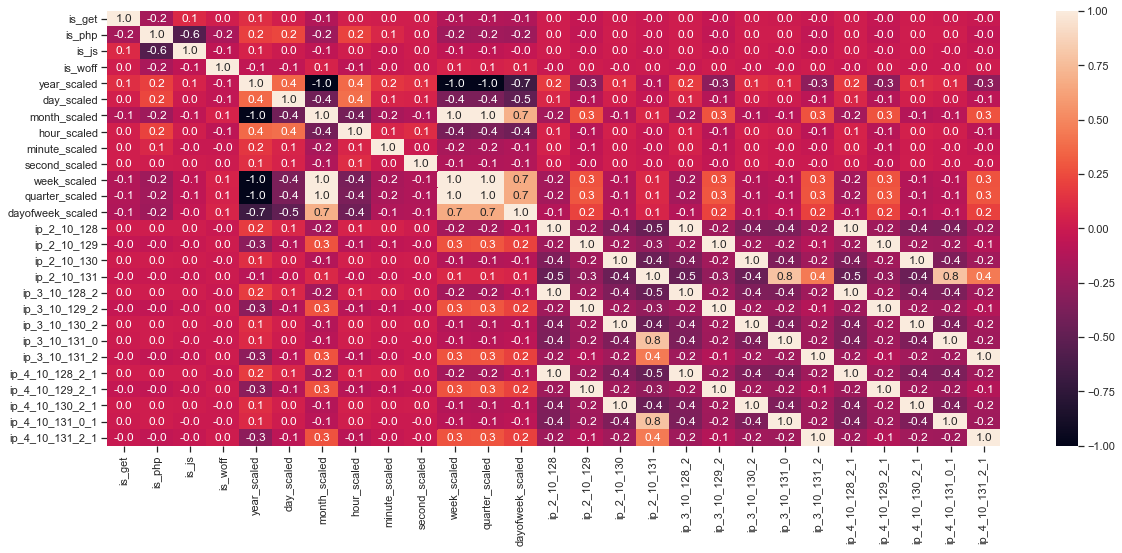

In [38]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(20,8))
sns.heatmap(data_scaled.corr(), ax=ax, annot=True, fmt='.1f')

In [39]:
# Набор данных с признаками даты-времени, отображенными на круг
data_round = data[url_features + dt_features_round].copy()
for col in df_ip.columns:
    if len(df_ip[col].unique()) > 1:
        data_round[col] = df_ip[col]

In [40]:
data_round.head()

,is_get,is_php,is_js,is_woff,year_round,day_cos,day_sin,month_cos,month_sin,hour_cos,...,ip_3_10_128_2,ip_3_10_129_2,ip_3_10_130_2,ip_3_10_131_0,ip_3_10_131_2,ip_4_10_128_2_1,ip_4_10_129_2_1,ip_4_10_130_2_1,ip_4_10_131_0_1,ip_4_10_131_2_1
0,1,1,0,0,1,0.918958,-0.394356,0.866025,-0.5,6.123234e-17,...,1,0,0,0,0,1,0,0,0,0
1,0,1,0,0,1,0.918958,-0.394356,0.866025,-0.5,6.123234e-17,...,1,0,0,0,0,1,0,0,0,0
2,1,1,0,0,1,0.918958,-0.394356,0.866025,-0.5,6.123234e-17,...,1,0,0,0,0,1,0,0,0,0
3,1,0,1,0,1,0.918958,-0.394356,0.866025,-0.5,6.123234e-17,...,0,0,0,0,1,0,0,0,0,1
4,1,0,1,0,1,0.918958,-0.394356,0.866025,-0.5,6.123234e-17,...,0,0,1,0,0,0,0,1,0,0


<AxesSubplot:>

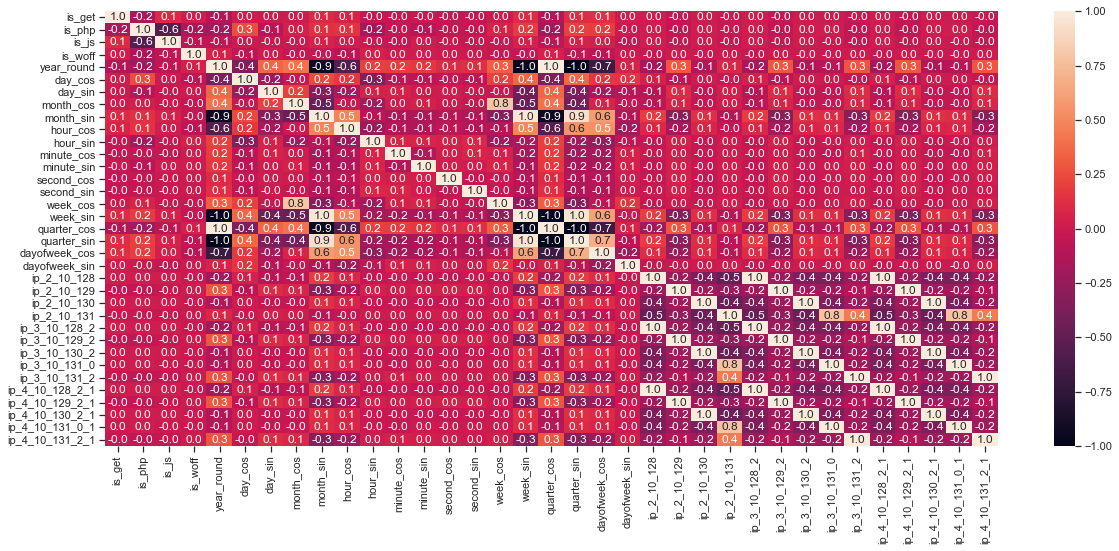

In [41]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(20,8))
sns.heatmap(data_round.corr(), ax=ax, annot=True, fmt='.1f')

In [42]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.05, a-0.05, str(round(b,3)), color='white')
        plt.show()    

In [43]:
data_dict = {'scaled': data_scaled, 'round': data_round}

In [44]:
clas_models_dict = {'LogR': LogisticRegression(max_iter=1000), 
                    'KNN_5':KNeighborsClassifier(n_neighbors=5),
                    'Tree':DecisionTreeClassifier(),
                    'GB': GradientBoostingClassifier(),
                    'RF':RandomForestClassifier(n_estimators=50, random_state=1, max_depth=3)}

In [45]:
def test_models(clas_models_dict, data_dict):
    logger = MetricLogger()
    for model_name, model in tqdm.tqdm(clas_models_dict.items()):
        for df_name, df in data_dict.items():
            scores = cross_val_score(model, df, data['status_le'], 
                                     cv=3, scoring='roc_auc_ovr_weighted')
            logger.add(df_name, model_name, np.mean(scores))
    return logger

In [46]:
%%time
logger = test_models(clas_models_dict, data_dict)

100%|██████████| 5/5 [01:04<00:00, 12.94s/it]

Wall time: 1min 4s


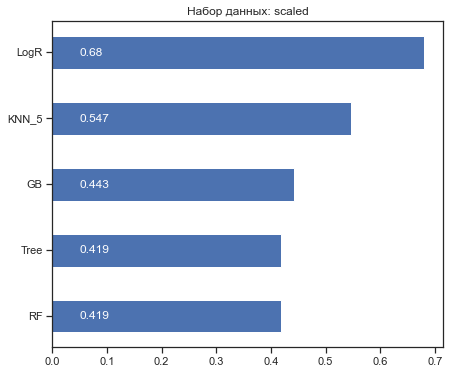

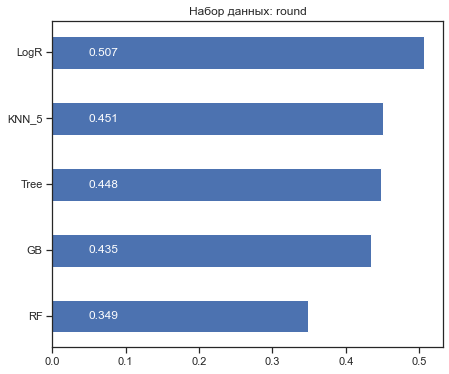

In [47]:
# Построим графики метрик качества модели
for df_name in data_dict:
    logger.plot('Набор данных: ' + df_name, df_name, figsize=(7, 6))

In [48]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, title, figsize=(20,8)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.1, b+0.005, str(round(b,3)))
    plt.show()
    return labels, data

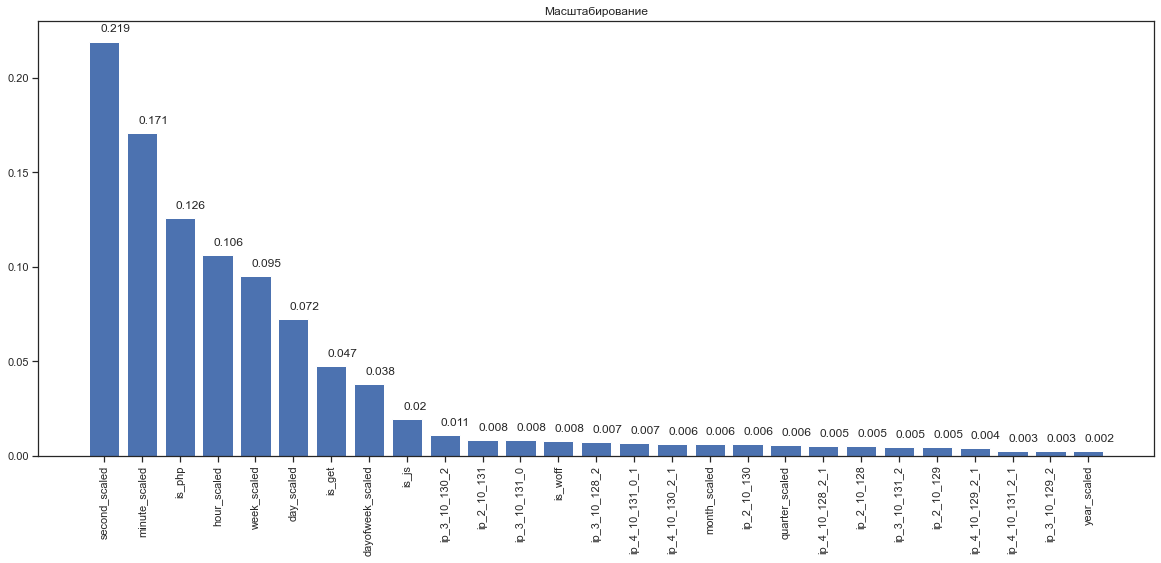

In [49]:
tree_scaled = DecisionTreeClassifier()
tree_scaled.fit(data_scaled, data['status_le'])
_,_=draw_feature_importances(tree_scaled, data_scaled, 'Масштабирование')

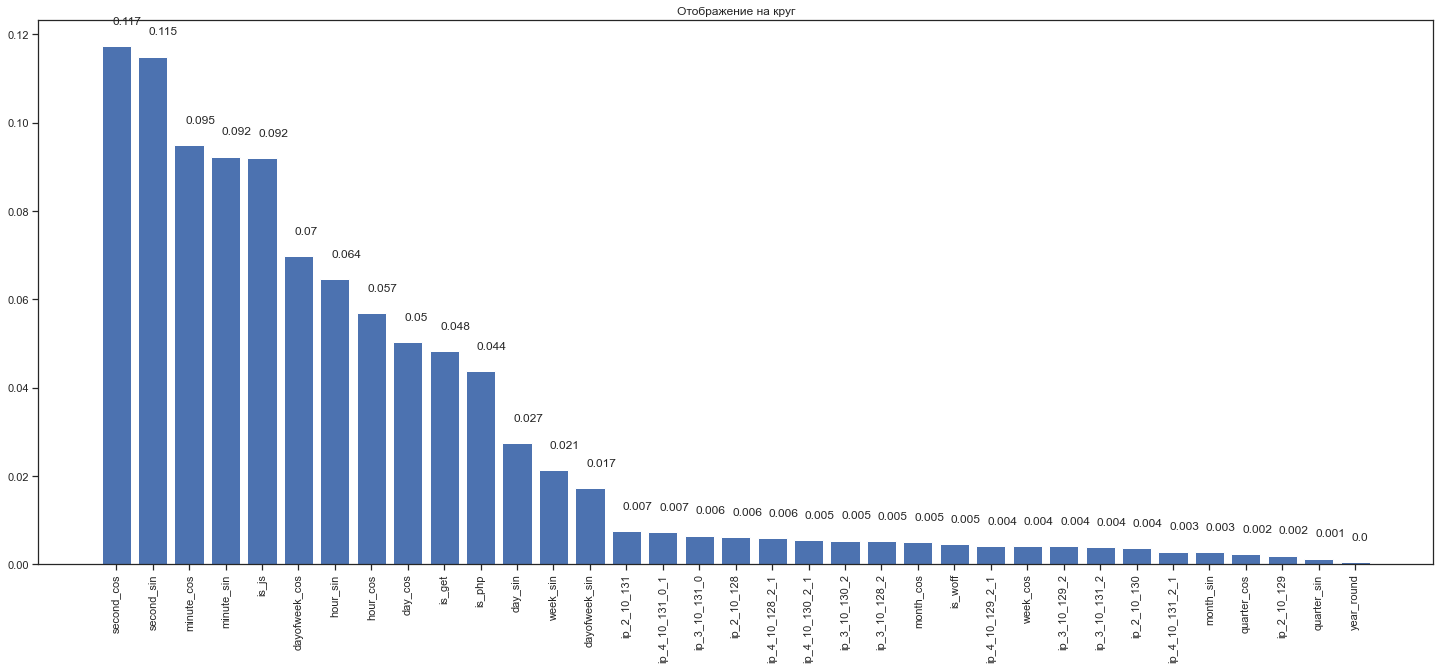

In [50]:
tree_round = DecisionTreeClassifier()
tree_round.fit(data_round, data['status_le'])
_,_=draw_feature_importances(tree_round, data_round, 'Отображение на круг', figsize=(25,10))

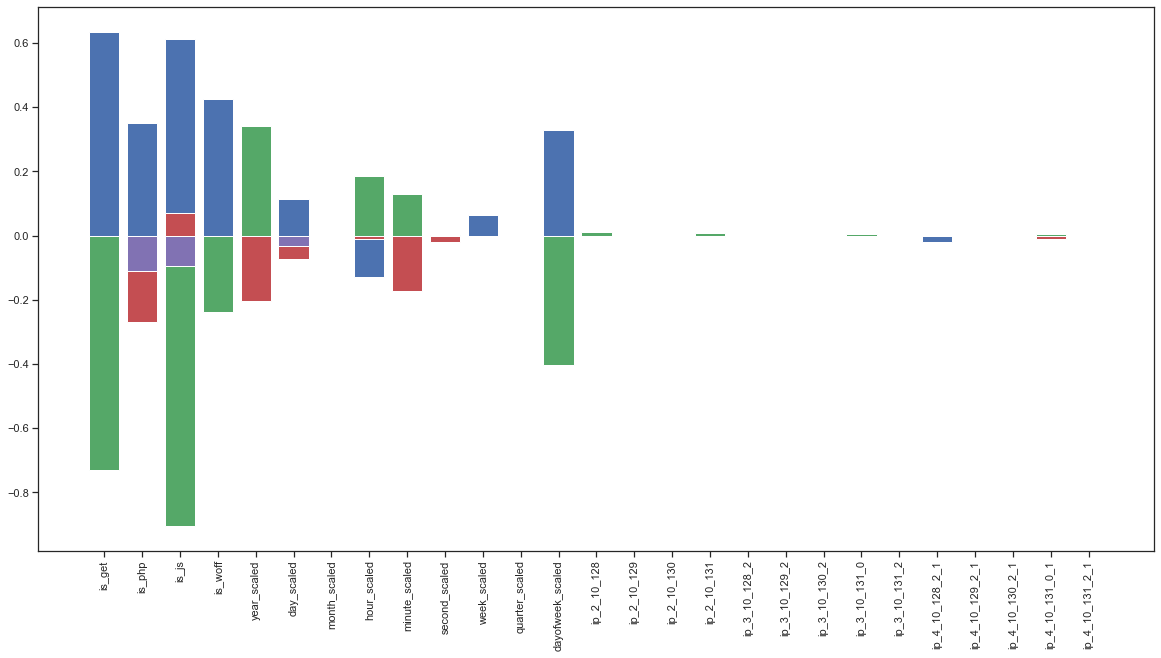

In [51]:
# Используем L1-регуляризацию
e_ls1 = LinearSVC(C=0.01, penalty="l1", max_iter=5000, dual=False)
e_ls1.fit(data_scaled, data['status_le'])
# Коэффициенты регрессии
labels = data_scaled.columns
fig, ax = plt.subplots(figsize=(20,10))
ind = np.arange(len(labels))
plt.xticks(ind, labels, rotation='vertical')
for i in range(len(e_ls1.classes_)):
    plt.bar(ind, list(e_ls1.coef_[i]))
plt.show()

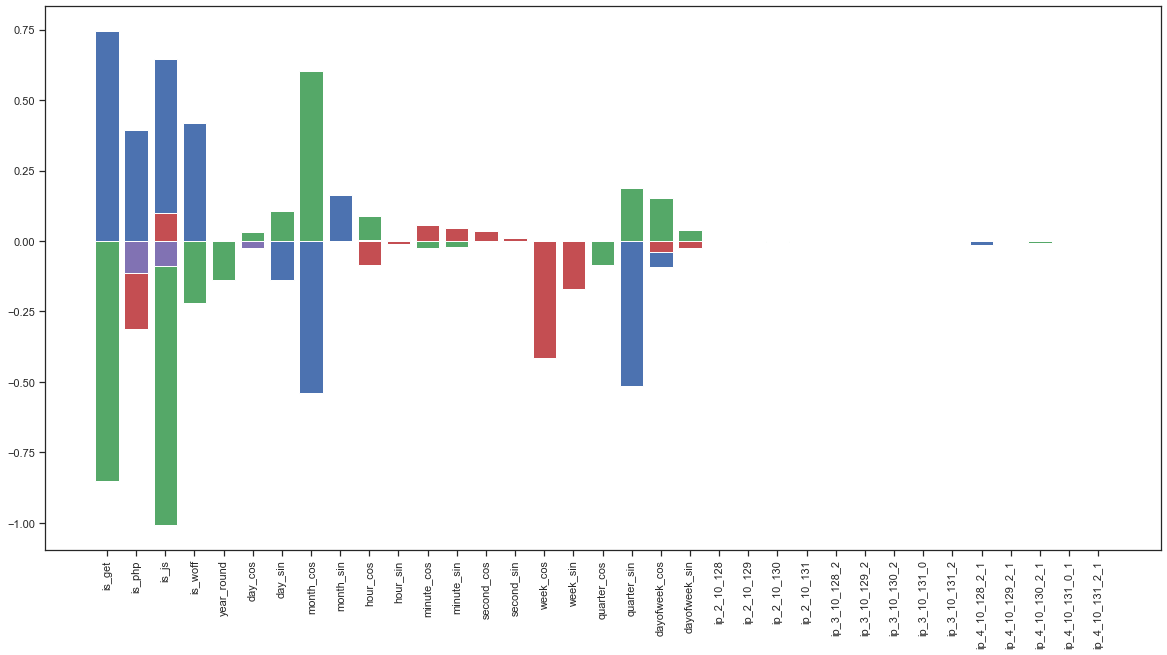

In [52]:
# Используем L1-регуляризацию
e_ls2 = LinearSVC(C=0.01, penalty="l1", max_iter=5000, dual=False)
e_ls2.fit(data_round, data['status_le'])
# Коэффициенты регрессии
labels = data_round.columns
fig, ax = plt.subplots(figsize=(20,10))
ind = np.arange(len(labels))
plt.xticks(ind, labels, rotation='vertical')
for i in range(len(e_ls2.classes_)):
    plt.bar(ind, list(e_ls2.coef_[i]))
plt.show()

Линейная модель в большей степени опирается на признаки sin, cos.

## Строковые признаки

В качестве примера работы со стороковыми признаками рассмотрим соревнование по определении силы пароля: https://www.kaggle.com/bhavikbb/password-strength-classifier-dataset

Исходное множество $X$ содержит только пароль. Необходимо выделить признаки из строки пароля для решения задачи.

Можно предложить два варианта решения (или их комбинацию):

**1) Побуквенное построение [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF) матрицы:**
- Буква соответствует столбцу TF-IDF-матрицы.
- Строка пароля соответствует строке матрицы.
- Возможен вариант с использованием буквенных N-грамм.

Пример решения - https://www.kaggle.com/pratibhas/password-strength-classifier 

**2) Выделение признаков из строки:**
- Длина строки.
- Количество прописных и строчных букв, гласных и согласных звуков.
- Количество цифр.
- Количество специальных символов.
- Цифровые паттерны, например год.
- Клавиатурные паттерны "qwerty", "qaz".

Пример решения - https://www.kaggle.com/yuv123bs/password-strength-classifier

**Выводы:**
- Оба решения обеспечили почти 100% точность.
- В первом случае точности удалось достигнуть только с помощью очень сильного классификатора (градиентного бустинга).
- Во втором случае точности удалось достигнуть с помощью логистической регресии, этот метод в первом решении показал худшие результаты.
- Выделение признаков во втором случае было реализовано лучше, чем в первом случае.

### Дополнительные источники
- [Открытый курс машинного обучения. Тема 6. Построение и отбор признаков](https://habr.com/ru/company/ods/blog/325422/)
- [Feature Engineering, о чём молчат online-курсы](https://habr.com/ru/company/mailru/blog/346942/)
- [Discover Feature Engineering, How to Engineer Features and How to Get Good at It](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)
- https://heartbeat.fritz.ai/hands-on-with-feature-engineering-techniques-variables-types-b2120e534680
- https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection
- https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2
- https://hammer.figshare.com/articles/thesis/Encoding_IP_Address_as_a_Feature_for_Network_Intrusion_Detection/11307287
- https://hammer.figshare.com/articles/thesis/Encoding_IP_Address_as_a_Feature_for_Network_Intrusion_Detection/11307287